# Introduction

Between 2021 and 2025, I was tasked with developing and coordinating STEM outreach events for the Department of Defense (DoD). This program reached approximately 1650+ students at 5 schools in the Washington Metropolitan Area. From the beginning, I used Google Forms to measure several Key Performance Indicators (KPIs), including student confidence in making future contributions to STEM, student likelihood to use DoD resources, and student engagement with the event's guest speaker and their demonstration. The program collected 700+ anonymous student exit survey results.

For improved program implementation in the future, I incorporated this exit survey data into an audience segmentation analysis using an unsupervised (unlabelled) machine learning classification technique called K-Means Clustering. From the results of this clustering method, I observed three students groups in the dataset and developed program implementation recommendations for each group based on its characteristics. 

The following code describes the process by which I segmented the audience data. Additionally, I produced several other brief data analyses and visualizations for the final report submission to the DoD. These items are included in the final two sections of this notebook.

# Setup

In [11]:
# Install necessary libraries (uncomment next line if needed to install missing libraries)
# !pip install pandas numpy matplotlib seaborn scikit-learn

# Import necessary libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
import numpy as np
import seaborn as sns

# Finding Optimal Number of Clusters

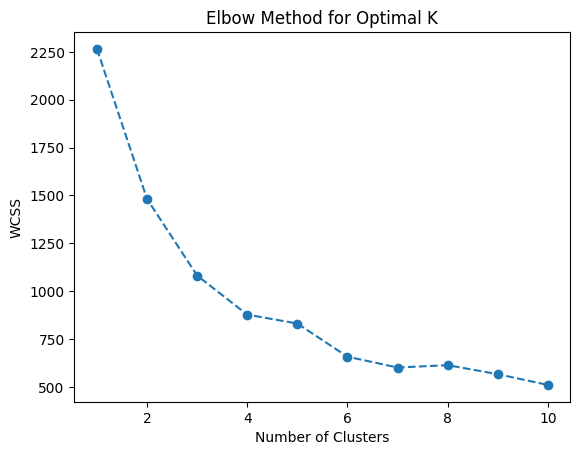

In [12]:
# Load survey data and assign to variable df
df = pd.read_csv("../_Project Datasets/K-Means Clustering Analysis Input Data.csv")

# Select relevant features for clustering
features = df[['Confidence', 'Likelihood', 'Engagement']]

# Standardize the data and assign to variable scaled_features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform Within-Cluster Sum of Squares (WCSS) method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)
    
# Plot the elbow method graph
# Plot shows a decrease in WCSS as the number of clusters increases
# A sharp decrease followed by a plateau indicates the optimal number of clusters
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

# K-Means Clustering Analysis

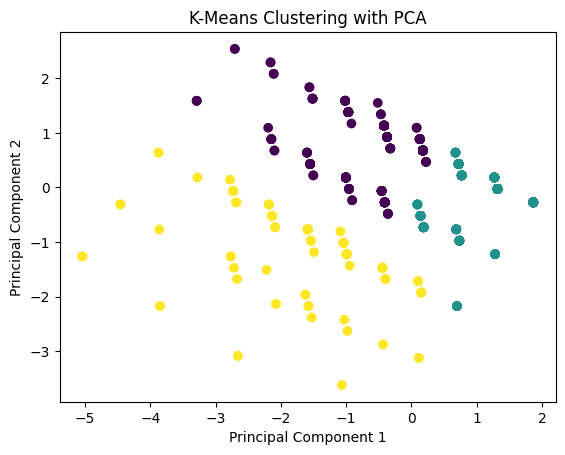

In [13]:
# From my analysis of the plot, I determined the optimal number of clusters to be 3.
optimal_k = 3

# Initialize KMeans with the optimal number of clusters and fit the model to the scaled features from the previous step
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
df["Cluster"] = kmeans.fit_predict(scaled_features)

# Visualize the clusters using Principal Component Analysis (PCA)
# PCA is a dimensionality reduction technique that transforms the data into a lower-dimensional space
# This is useful for visualizing high-dimensional data in 2D or 3D plots
pca = PCA(n_components=2)

# Fit PCA on the scaled features and transform them to 2D
pca_features = pca.fit_transform(scaled_features)

# Add the PCA components to the DataFrame for visualization
df['PC1'], df['PC2'] = pca_features[:, 0], pca_features[:, 1]

# Create and show a scatter plot of the PCA components, colored by cluster
plt.scatter(df["PC1"], df["PC2"], c=df["Cluster"], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering with PCA')
plt.show()

# 3D Visualization of the Clusters

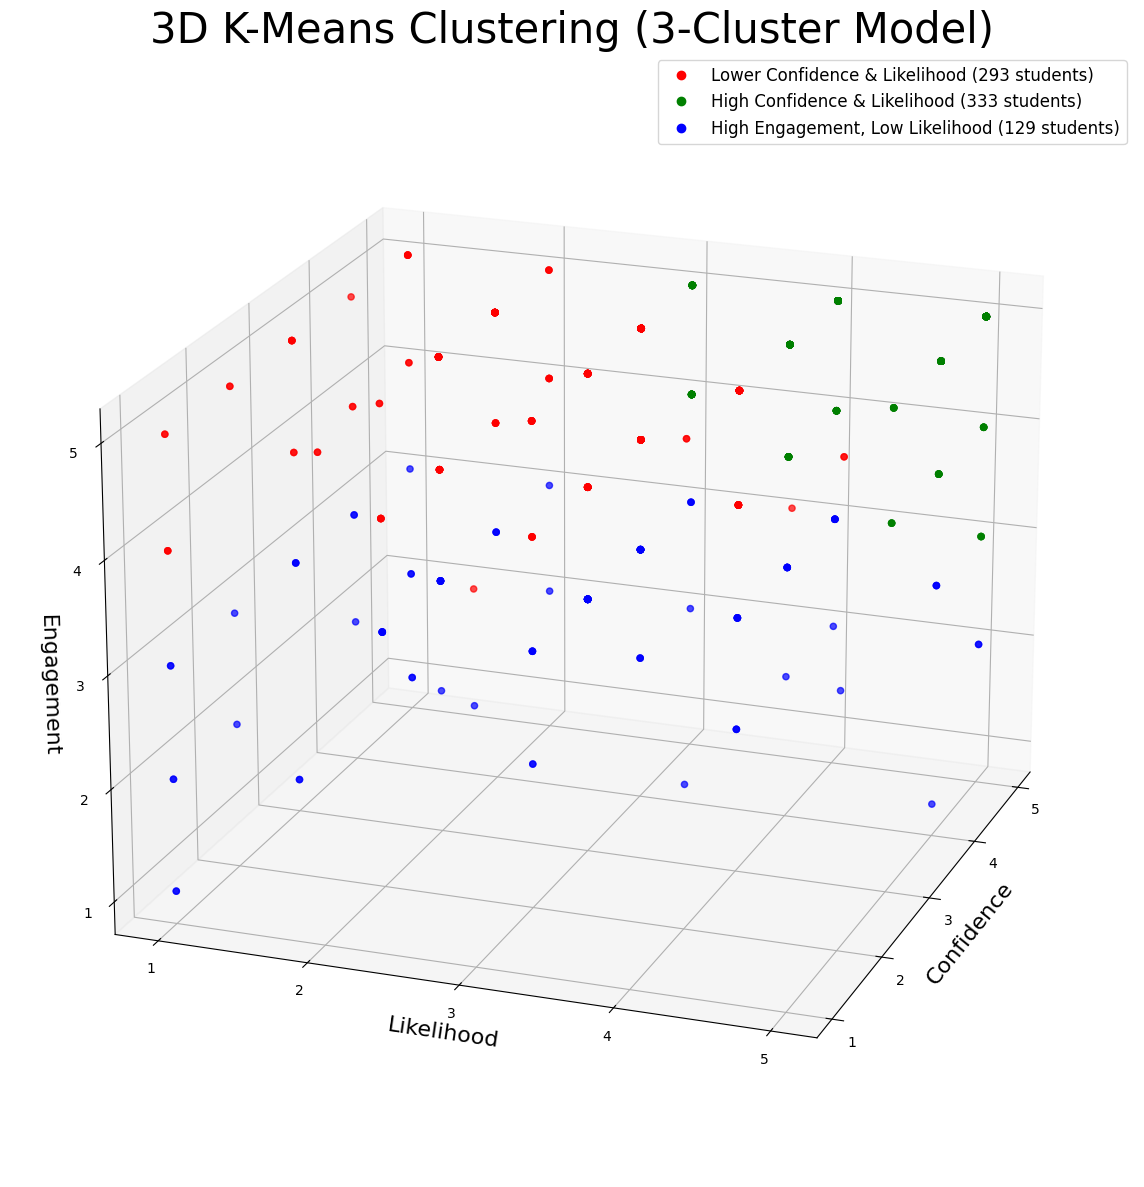

In [14]:
# Select only the numerical columns for scaling, EXCLUDING the 'Cluster_3_Label' column
numerical_df = df[['Confidence', 'Likelihood', 'Engagement']]  # Select numerical columns only

# Ensure all columns in numerical_df are numeric
numerical_df = numerical_df.select_dtypes(include=['number'])

# Standardize the dataset for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_df)  # Scale only the numerical data

# Apply K-Means with 3 clusters
kmeans_3 = KMeans(n_clusters=3, init='k-means++', random_state=42)
df["Cluster_3"] = kmeans_3.fit_predict(scaled_data)

# Select features for plotting and ensure they are numeric
features_for_plotting = df[['Confidence', 'Likelihood', 'Engagement']].apply(pd.to_numeric, errors='coerce')

# Drop (remove) rows with NaN values in any of the selected features, preserving the 'Cluster_3' column for labelling data
valid_data = df.loc[features_for_plotting.dropna().index, ['Confidence', 'Likelihood', 'Engagement', 'Cluster_3']]

# Define cluster colors
colors = ['red', 'green', 'blue'] 

# Create the plot figure for display and then add subplot for 3D projected grid
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(121, projection='3d')

# Create a 3D scatter plot of the data points, colored by cluster
ax.scatter(valid_data["Confidence"],
           valid_data["Likelihood"],
           valid_data["Engagement"],
           c=valid_data["Cluster_3"],  # Color points based on Cluster_3
           cmap=matplotlib.colors.ListedColormap(colors),
           alpha=0.7)

# Label axis and adjust fontsize
ax.set_xlabel("Confidence", fontsize=16)
ax.set_ylabel("Likelihood", fontsize=16)
ax.set_zlabel("Engagement", fontsize=16)
ax.set_title("3D K-Means Clustering (3-Cluster Model)",fontsize=30)

# Adjust layout to prevent labels from being cut off
ax.view_init(elev=20, azim=20)
fig.subplots_adjust(right=.95)
ax.invert_xaxis()

# Get unique cluster labels and their counts
cluster_labels, cluster_counts = np.unique(valid_data["Cluster_3"], return_counts=True)

# Define resulting cluster names
cluster_labels = {
    0: "Lower Confidence & Likelihood",
    1: "High Confidence & Likelihood",
    2: "High Engagement, Low Likelihood"
}

# Create legend entries with labels and counts
legend_entries = [plt.Line2D([0], [0], marker='o', color=colors[label], label=f'{cluster_labels[label]} ({count} students)',
                             linestyle='None')
                 for label, count in zip(cluster_labels, cluster_counts)]

# Add legend to the plot
ax.legend(handles=legend_entries, loc='best', fontsize='large')

# Set tick locations and format as integers for all axes
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Set x-axis ticks to integers
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))  # Format x-axis tick labels as integers
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))  # Set y-axis ticks to integers
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))  # Format y-axis tick labels as integers
ax.zaxis.set_major_locator(ticker.MultipleLocator(1))  # Set z-axis ticks to integers
ax.zaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))  # Format z-axis tick labels as integers

# Display final plot
plt.show()

# Simple Distribution of Clusters

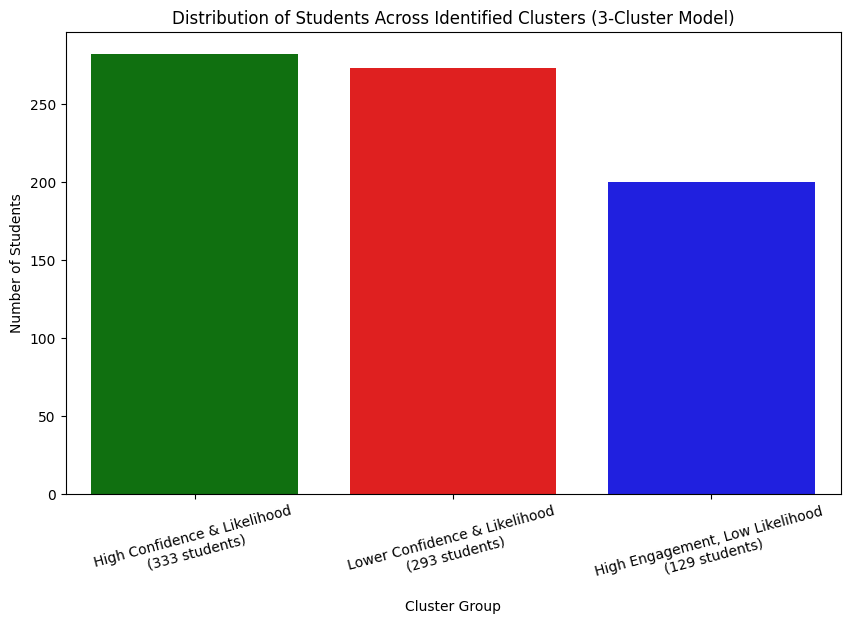

In [22]:
# Reload survey data and assign to variable df
df = pd.read_csv("../_Project Datasets/K-Means Clustering Analysis Input Data.csv")

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Re-apply KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
df["Cluster_3"] = kmeans.fit_predict(scaled_data)

# Map labels
df["Cluster_3_Label"] = df["Cluster_3"].map(cluster_labels)

# Refine previous cluster labels by adding student count for each column
cluster_labels = {
    0: "High Engagement, Low Likelihood\n(129 students)",
    1: "Lower Confidence & Likelihood\n(293 students)",
    2: "High Confidence & Likelihood\n(333 students)"
}

# Count of students in each labeled cluster
cluster_counts_labeled = df["Cluster_3_Label"].value_counts()

# Add cluster labels to the DataFrame for plotting
plot_df = cluster_counts_labeled.reset_index()
plot_df.columns = ["Cluster_Label", "Student_Count"]

# Create the bar plot
plt.figure(figsize=(10, 6))

# Use Cluster_Label for x-axis and Student_Count for y-axis
# Use hue to differentiate clusters in the bar plot
# Set the color palette for the bars
sns.barplot(data=plot_df,x="Cluster_Label", y="Student_Count", hue="Cluster_Label", palette=["green", "red", "blue"], legend=False)

# Set the title and labels
plt.xlabel("Cluster Group")
plt.ylabel("Number of Students")
plt.title("Distribution of Students Across Identified Clusters (3-Cluster Model)")
plt.xticks(rotation=15)  # Adjust label rotation for clarity

# Show the plot
plt.show()

# Average Engagement Ratings of Guest Speakers Over Time

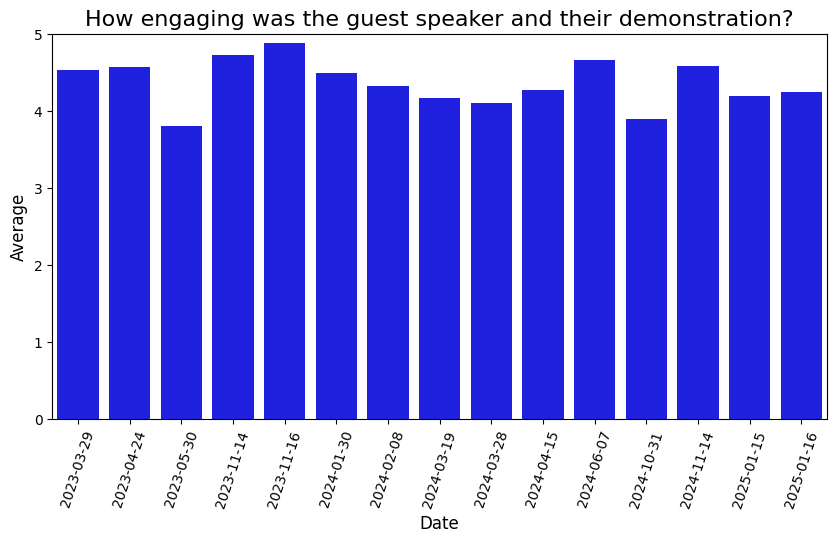

In [ ]:
# Set up data structure based on the original CSV file
data = {
    "Date": ["2023-03-29", "2023-04-24", "2023-05-30", "2023-11-14", "2023-11-16",
             "2024-01-30", "2024-02-08", "2024-03-19", "2024-03-28", "2024-04-15",
             "2024-06-07", "2024-10-31", "2024-11-14", "2025-01-15", "2025-01-16"],
    "Average": [4.53, 4.57, 3.80, 4.73, 4.88,
                4.50, 4.33, 4.17, 4.10, 4.27,
                4.66, 3.90, 4.58, 4.2, 4.25]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Convert date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Set figure size
plt.figure(figsize=(10, 5))

# Create bar plot
sns.barplot(x=df["Date"], y=df["Average"], color="blue")

# Customize labels and title
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average", fontsize=12)
plt.title("How engaging was the guest speaker and their demonstration?", fontsize=16)

# Format x-axis labels for readability
plt.xticks(rotation=72)

# Set Y-axis range to match example
plt.ylim(0, 5)

# Show the plot
plt.show()

# Analysis of Repeat Speaker Engagement Scores

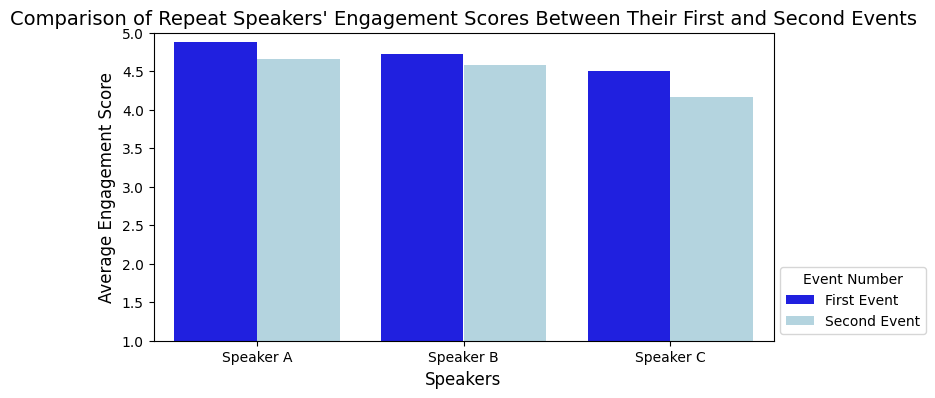

In [ ]:
# Set up data structure
data = {
    "Speaker": ["Speaker A", "Speaker A", "Speaker B", "Speaker B", "Speaker C", "Speaker C"],
    "Event Number": ["First Event", "Second Event", "First Event", "Second Event", "First Event", "Second Event"],
    "Engagement Score": [4.88, 4.66, 4.73, 4.58, 4.50, 4.17]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Set up the plotting style
plt.figure(figsize=(8, 4))
sns.barplot(x="Speaker", y="Engagement Score", hue="Event Number", data=df, palette=["Blue", "LightBlue"])

# Customize labels and title
plt.xlabel("Speakers", fontsize=12)
plt.ylabel("Average Engagement Score", fontsize=12)
plt.title("Comparison of Repeat Speakers' Engagement Scores Between Their First and Second Events", fontsize=14)
plt.ylim(1, 5)

# Display the legend
plt.legend(title="Event Number")

# Position the legend outside to the right
sns.move_legend(plt.gca(), "lower left", bbox_to_anchor=(1, 0))

# Show the plot
plt.show()
